## Downloading Modular PyTorch Scripts

In [1]:
import os
from pathlib import Path
import requests

base_url = r"https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular"


files = [
    "data_setup.py",
    "engine.py",
    "model_builder.py",
    "predictions.py",
    "train.py",
    "utils.py"]

target_dir = Path("going_modular")

if target_dir.exists():
    print("Already exists")
else:
    print("Couldn't find, downloading......")
    target_dir.mkdir(parents=True, exist_ok=True)

    for file_name in files:
        file_url = f"{base_url}/{file_name}"
        response = requests.get(file_url)
        response.raise_for_status()

        file_path = target_dir / file_name
        file_path.write_text(response.text)

    print("Downloaded!")

Couldn't find, downloading......
Downloaded!


## Downloading `helper_functions.py` from GitHub

In [2]:
import os
import requests

url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"

response = requests.get(url)
response.raise_for_status()

with open("helper_functions.py", 'wb') as f:
    f.write(response.content)

## `create_effnetb2_model` Function

In [3]:
from torch import nn
import torch
import torchvision

def create_effnetb2_model(num_classes: int=101,
                          seed: int=42):

    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transformer = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed=seed)

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes))

    return model, transformer

In [4]:
food101_effnet, effnetb2_transforms = create_effnetb2_model(num_classes=101,
                                                            seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 47.0MB/s]


## Food101 Training Transforms with EfficientNet-B2

In [5]:
import torchvision

food101_effnet_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

food101_effnet_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

## Food101 Dataset Setup with EfficientNet-B2

In [6]:
from torchvision import datasets
from pathlib import Path

data_dir = Path("data")

train_data_effnet = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_effnet_train_transforms,
                              download=True)

test_data_effnet = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,
                             download=True)

100%|██████████| 5.00G/5.00G [04:34<00:00, 18.2MB/s]


In [7]:
food101_class_names = train_data_effnet.classes
food101_class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

## `split_dataset` Function

In [8]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float=0.2,
                  seed: int=42):

    length_1 = int(len(dataset) * split_size) # number of samples in the first split (20% of dataset length)
    length_2 = len(dataset) - length_1 # remainder (80%)

    print(f"[INFO] splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

    random_split_1, random_split_2 = torch.utils.data.random_split(dataset=dataset,
                                                                lengths=[length_1, length_2],
                                                                generator=torch.manual_seed(seed))
    return random_split_1, random_split_2

## Creating 20% Subsets of Food101 with EfficientNet-B2

In [9]:
train_data_effnet_food101_20_percent, _ = split_dataset(dataset=train_data_effnet,
                                                 split_size=0.2)

test_data_effnet_food101_20_percent, _ = split_dataset(dataset=test_data_effnet,
                                                split_size=0.2)

[INFO] splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] splitting dataset of length 25250 into splits of size: 5050 and 20200


In [10]:
len(train_data_effnet_food101_20_percent), len(test_data_effnet_food101_20_percent)

(15150, 5050)

##  Food101 Dataloaders (20% Subsets with EfficientNet-B2)

In [11]:
NUM_WORKERS = 2
BATCH_SIZE = 32

train_dataloader_effnet_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_effnet_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)


test_dataloader_effnet_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_effnet_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False,
                                                                  num_workers=NUM_WORKERS)

## Training EfficientNet-B2 on Food101 (20% Subsets)

In [12]:
from going_modular import engine

device = 'cuda' if torch.cuda.is_available() else 'cpu'

optimizer = torch.optim.Adam(params=food101_effnet.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

torch.manual_seed(42)

effnetb2_food101_results = engine.train(model=food101_effnet,
                                        train_dataloader=train_dataloader_effnet_food101_20_percent,
                                        test_dataloader=test_dataloader_effnet_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


## Plotting Loss Curves for EfficientNet-B2 on Food101

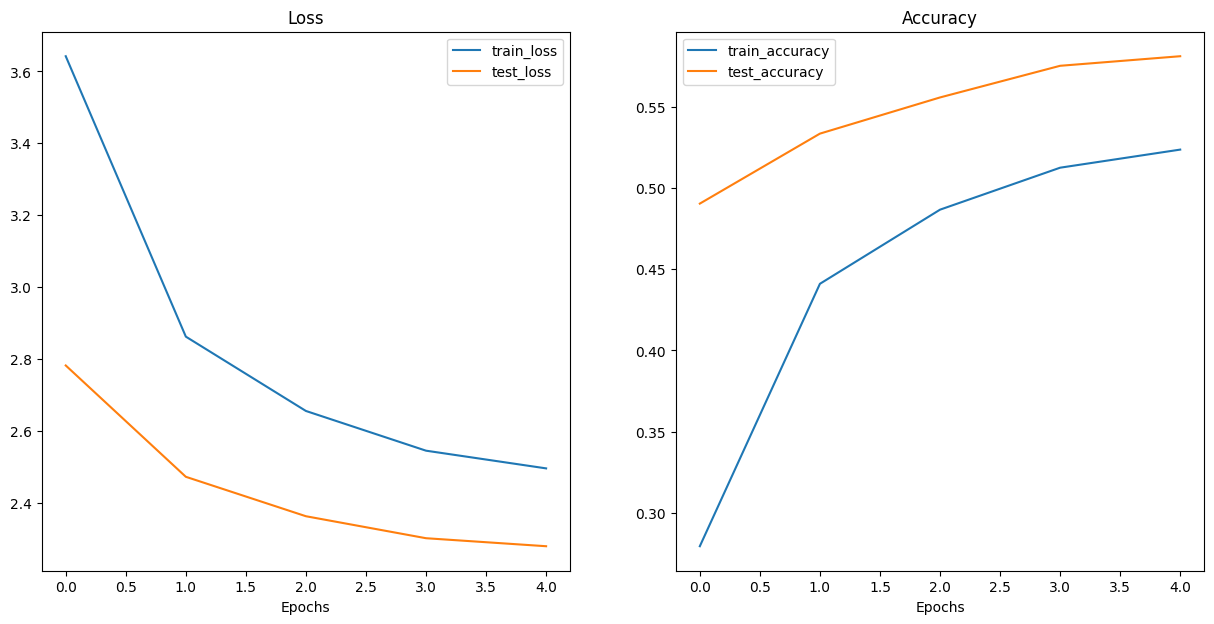

In [13]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

## `create_vit_model` Function

In [14]:
def create_vit_model(num_classes:int=101,
                     seed:int=42):

    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
      param.requires_grad = False

    torch.manual_seed(seed=seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_classes))

    return model, transforms

In [15]:
food101_vit, vit_transforms = create_vit_model(num_classes=101,
                                               seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:05<00:00, 61.6MB/s]


## Food101 Training Transforms with ViT-16

In [16]:
import torchvision

food101_vit_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms
])

food101_vit_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

## Food101 Dataset Setup with ViT-16

In [17]:
from torchvision import datasets
from pathlib import Path

data_dir = Path("data")

train_data_vit = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_vit_train_transforms,
                              download=True)

test_data_vit = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_transforms,
                             download=True)

## Creating 20% Subsets of Food101 with ViT-16

In [18]:
train_data_vit_food101_20_percent, _ = split_dataset(dataset=train_data_vit,
                                                 split_size=0.2)

test_data_vit_food101_20_percent, _ = split_dataset(dataset=test_data_vit,
                                                split_size=0.2)

[INFO] splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] splitting dataset of length 25250 into splits of size: 5050 and 20200


##  Food101 Dataloaders (20% Subsets with ViT-16)

In [19]:
NUM_WORKERS = 2
BATCH_SIZE = 32

train_dataloader_vit_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_vit_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)


test_dataloader_vit_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_vit_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False,
                                                                  num_workers=NUM_WORKERS)

## Training ViT-16 on Food101 (20% Subsets)

In [20]:
from going_modular import engine

device = 'cuda' if torch.cuda.is_available() else 'cpu'

optimizer = torch.optim.Adam(params=food101_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

torch.manual_seed(42)

vit_food101_results = engine.train(model=food101_vit,
                                        train_dataloader=train_dataloader_vit_food101_20_percent,
                                        test_dataloader=test_dataloader_vit_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8532 | train_acc: 0.4279 | test_loss: 2.0665 | test_acc: 0.6257
Epoch: 2 | train_loss: 2.2209 | train_acc: 0.5931 | test_loss: 1.9249 | test_acc: 0.6657
Epoch: 3 | train_loss: 2.0587 | train_acc: 0.6439 | test_loss: 1.8675 | test_acc: 0.6981
Epoch: 4 | train_loss: 1.9557 | train_acc: 0.6810 | test_loss: 1.8514 | test_acc: 0.6989
Epoch: 5 | train_loss: 1.8883 | train_acc: 0.7009 | test_loss: 1.8297 | test_acc: 0.7078


In [21]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary

summary(model=food101_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Plotting Loss Curves for ViT-16 on Food101

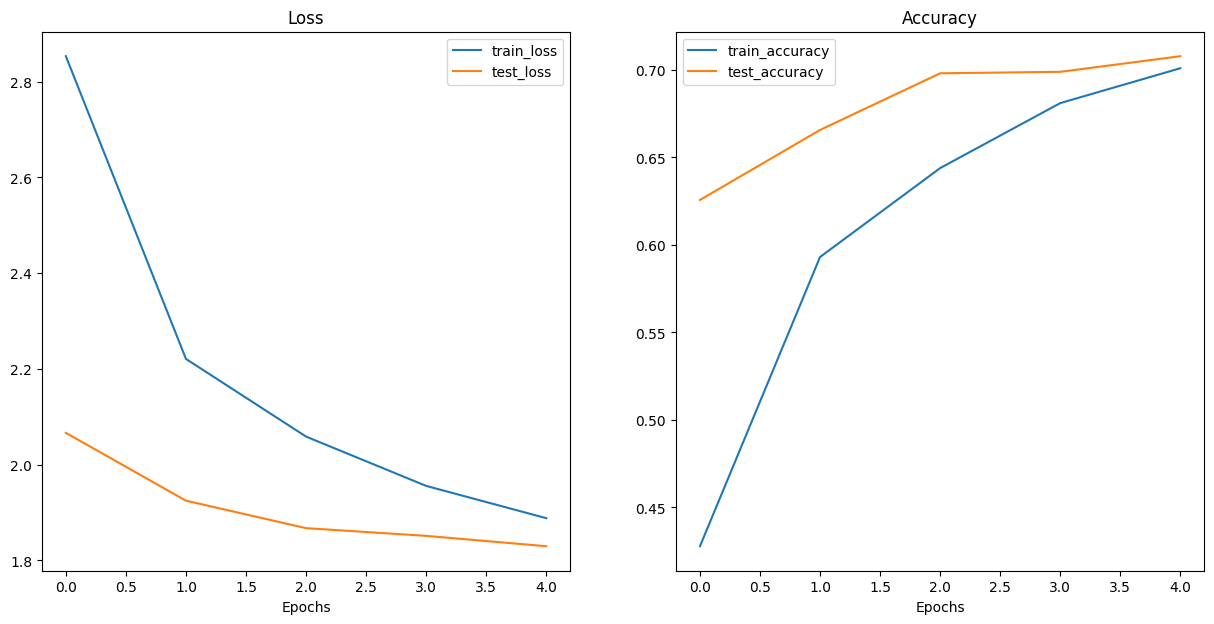

In [22]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_food101_results)

## Saving the ViT-16 Model

In [23]:
model_path = Path("model")
model_path.mkdir(exist_ok=True, parents=True)

model_name = "food101_vit_features_extraction.pth"

torch.save(food101_vit.state_dict(), model_path/model_name)

## Checking Saved Food101 ViT Model File Size


In [24]:
food101_vit_size = Path(r"model/food101_vit_features_extraction.pth").stat().st_size / (1024*1024)
print(f"our food101_vit_model is: {round(food101_vit_size, 2)} MB")

our food101_vit_model is: 327.65 MB


## Turning our FoodVision Big model into a deployable app


```
demos/
  foodvision_big/
    food101_vit_features_extraction.pth
    app.py
    class_names.txt
    examples/
      waffles_example.jpg
      tacos_example.jpg
      oysters_example.jpg
    model.py
    requirements.txt
```

## Move the Trained Model File into the Demo Directory

In [42]:
!mv model/food101_vit_features_extraction.pth demos/foodvision_big/

## Create the FoodVision Big demo and / examples directories

In [72]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

## Copy example images into the FoodVision Big demo

In [73]:
!cp data/food-101/images/hot_dog/1068951.jpg demos/foodvision_big/examples/hot_dog_example.jpg
!cp data/food-101/images/cup_cakes/1003128.jpg demos/foodvision_big/examples/cup_cakes_example.jpg
!cp data/food-101/images/hamburger/100057.jpg demos/foodvision_big/examples/hamburger_example.jpg

In [29]:
!ls demos/foodvision_big/examples

oyster_example.jpg  taco_example.jpg  waffle_example.jpg


## Preview the first 5 Food101 class names

In [30]:
food101_class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

## Saving Food101 class names to file (`class_names.txt`)

In [65]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names to text file
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names))

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


## `model.py` - viT-16 for FoodVision Big

In [74]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision
from torch import nn

def create_vit_b16_model(num_classes: int, seed: int = 42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)


    model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

    return model, transforms

Overwriting demos/foodvision_big/model.py


## `requirements.text`

In [75]:
import torch
import torchvision
import gradio

print(torch.__version__)
print(torchvision.__version__)
print(gradio.__version__)

2.9.0+cu126
0.24.0+cu126
5.50.0


In [76]:
%%writefile demos/foodvision_big/requirements.text
torch=2.9.0
torchvision=0.24.0
gradio=5.50.0

Overwriting demos/foodvision_big/requirements.text


## `app.py` - Gradio Interface for FoodVision Big

In [78]:
# %%writefile demos/foodvision_big/app.py
import gradio as gr
import os
import torch
from demos.foodvision_big.model import create_vit_b16_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open(class_name_path, "r") as f:
    class_names = [food_name.strip() for food_name in f.readlines()]

# Create model and transforms
vit, vit_transforms = create_vit_b16_model(num_classes=101)

# Load saved weights
vit.load_state_dict(
    torch.load("demos/foodvision_big/food101_vit_features_extraction.pth",
               map_location=torch.device("cpu"))
)

def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = timer()

    # Transform the input image for use with ViT-16
    img = vit_transforms(img).unsqueeze(0)

    vit.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(vit(img), dim=1)

        pred_labels_and_probs = {}

        for i in range(len(class_names)):
            label = class_names[i]
            prob = float(pred_probs[0][i])
            pred_labels_and_probs[label] = prob

    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

# Create title, description and article
title = "FoodVision BIG 🍔👁💪"
description = "A [Vision Transformer (ViT-B/16)](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html) computer vision model to classify images [101 classes of food from the Food101 dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."  # FIXED: Updated description to ViT
article = "Thanks to [Daniel Bourke (mrdbourke)](https://github.com/mrdbourke/pytorch-deep-learning/)"

# Create example list
example_list = [["demos/foodvision_big/examples/" + example] for example in os.listdir("demos/foodvision_big/examples/")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b82fe9b70c0a6b22db.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
